## NASDAQ

In [1]:
## import packages
# the code is inspired by https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827
import math 
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
# import tensorflow's packages for building the LTSM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

nasdaq = yf.Ticker("^NDX").history(start="2009-01-01", end="2019-01-01")

sp500 = yf.Ticker("^GSPC").history(start="2009-01-01", end="2019-01-01")

dow_jones = yf.Ticker("^DJI").history(start="2009-01-01", end="2019-01-01")

In [27]:
print(nasdaq.info())
print(sp500.info())
print(dow_jones.info())

dow_jones

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2009-01-02 00:00:00-05:00 to 2018-12-31 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Volume        2516 non-null   int64  
 5   Dividends     2516 non-null   float64
 6   Stock Splits  2516 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 221.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2009-01-02 00:00:00-05:00 to 2018-12-31 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null 

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-01-02 00:00:00-05:00,8772.250000,9065.280273,8760.780273,9034.690430,213700000,0.0,0.0
2009-01-05 00:00:00-05:00,9027.129883,9034.370117,8892.360352,8952.889648,233760000,0.0,0.0
2009-01-06 00:00:00-05:00,8954.570312,9088.059570,8940.950195,9015.099609,215410000,0.0,0.0
2009-01-07 00:00:00-05:00,8996.940430,8996.940430,8719.919922,8769.700195,266710000,0.0,0.0
2009-01-08 00:00:00-05:00,8769.940430,8770.019531,8651.190430,8742.459961,226620000,0.0,0.0
...,...,...,...,...,...,...,...
2018-12-24 00:00:00-05:00,22317.279297,22339.869141,21792.199219,21792.199219,308420000,0.0,0.0
2018-12-26 00:00:00-05:00,21857.730469,22878.919922,21712.529297,22878.449219,433080000,0.0,0.0
2018-12-27 00:00:00-05:00,22629.060547,23138.890625,22267.419922,23138.820312,407940000,0.0,0.0


Text(0, 0.5, 'Price')

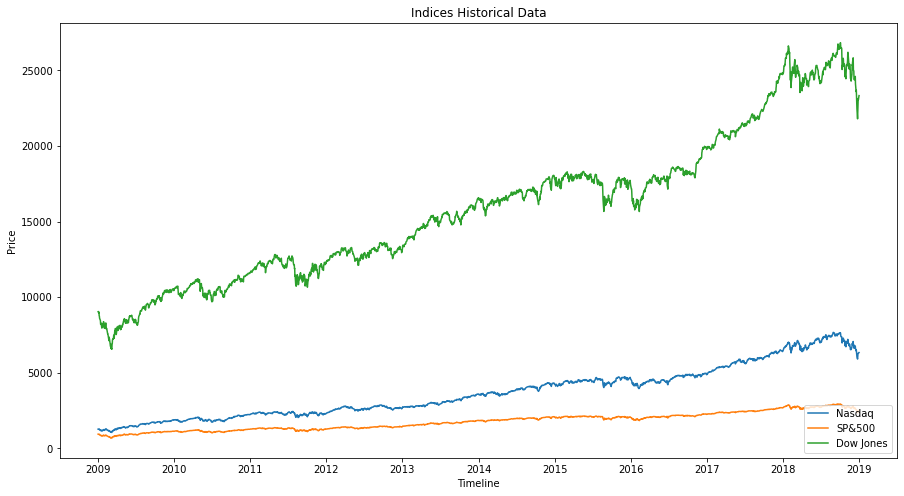

In [20]:
# Plotting the close prices for Nasdaq, sp500 and dow jones 
plt.figure(figsize=(15, 8)) # size of figure
plt.title('Indices Historical Data') # title 
plt.plot(nasdaq['Close']) # plot Close prices
plt.plot(sp500['Close']) #  ""
plt.plot(dow_jones['Close']) # ""
plt.legend(['Nasdaq', 'SP&500', "Dow Jones"], loc='lower right')
plt.xlabel('Timeline') 
plt.ylabel('Price')

In [4]:
close_nasqad = nasdaq['Close'] # extract closing prices
values_nasqad = close_nasqad.values # making in the price into a series
training_data_len_nasqad = math.ceil(len(values_nasqad)* 0.95) # we only need the 95% of the data set we have

scaler = MinMaxScaler(feature_range=(0,1)) # we try to normalize our data to values from 0 to 1 and then reshaping the data into a 2 dimensional array which is need 
# to make the LTSM model work later on
scaled_data_nasqad = scaler.fit_transform(values_nasqad.reshape(-1,1)) # here comes the reshaping

train_data_nasqad = scaled_data_nasqad[0: training_data_len_nasqad, :] # here are the training data taking place but only the 80% of the data set for each data set


x_train_nasqad = [] # creating an empty array that holds the feature data. We know that in machine learning, a feature is an individual measurable property or characteristic of a phenomenon
y_train_nasqad = [] # this array is the label data which is needed for the LSTM model 

for i in range(60, len(train_data_nasqad)): # 60-days window of historical prices of the feature data
    # Nasqad
    x_train_nasqad.append(train_data_nasqad[i-60:i, 0]) 
    y_train_nasqad.append(train_data_nasqad[i, 0]) #  60-days window as label data
    
x_train_nasqad, y_train_nasqad = np.array(x_train_nasqad), np.array(y_train_nasqad) # here we basically convert the feature data and the label data into an numpy array as tensorflow accepts only numpy array data when training
# such neural networks 
x_train_nasqad = np.reshape(x_train_nasqad, (x_train_nasqad.shape[0], x_train_nasqad.shape[1], 1)) # in the end we reshape the data in a 3 dimensional array part of the requirement of the LTSM model

In [29]:
# here is the test data 
test_data_nasqad = scaled_data_nasqad[training_data_len_nasqad-60: , : ] # extracting the last 20% data

x_test_nasqad = [] 
y_test_nasqad = values_nasqad[training_data_len_nasqad:]

for i in range(60, len(test_data_nasqad)):
    x_test_nasqad.append(test_data_nasqad[i-60:i, 0]) # append them into the array we created

x_test_nasqad = np.array(x_test_nasqad)
x_test_nasqad = np.reshape(x_test_nasqad, (x_test_nasqad.shape[0], x_test_nasqad.shape[1], 1)) 
print(len(test_data_nasqad))

185


In [6]:
model_nasqad = keras.Sequential()

#model_dow_jones =  keras.Sequential()

model_nasqad.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_nasqad.shape[1], 1))) # 100 network units and return_sequences is true when returns an output the same size as the layer before
model_nasqad.add(layers.LSTM(100, return_sequences=False)) # here the layer is set to false so returning the last output
model_nasqad.add(layers.Dense(25)) # type of layer in a deep neural network that use a linear operation where every input is connected to every output by a weight - 25 network units
model_nasqad.add(layers.Dense(1)) # 1 network unit
model_nasqad.summary() # some information

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
# training the models
model_nasqad.compile(optimizer='adam', loss='mean_squared_error') # adam optimiser a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# mean squared error as a loss function
model_nasqad.fit(x_train_nasqad, y_train_nasqad, batch_size= 1, epochs=3) # Batch size is a term used in machine learning and refers to the number of training examples utilized in one iteration 
# An epoch in neural networks is an iteration through the complete training dataset. After an epoch iteration is done, the model is evaluated in terms of accuracy

Epoch 1/3
2331/2331 [==============================] - 40s 16ms/step - loss: 0.0012
Epoch 2/3
2331/2331 [==============================] - 37s 16ms/step - loss: 3.7461e-04
Epoch 3/3
2331/2331 [==============================] - 38s 16ms/step - loss: 3.2102e-04


In [8]:
predictions_nasqad = model_nasqad.predict(x_test_nasqad)
predictions_nasqad = scaler.inverse_transform(predictions_nasqad)
root_mean_square_error_nasqad = np.sqrt(np.mean(predictions_nasqad - y_test_nasqad)**2)
print(root_mean_square_error_nasqad)

4/4 [==============================] - 1s 16ms/step
143.54911328125


                                 Close  Predictions
Date                                               
2018-07-03 00:00:00-04:00  7014.549805  6916.610352
2018-07-05 00:00:00-04:00  7101.049805  6905.890625
2018-07-06 00:00:00-04:00  7207.330078  6924.551270
2018-07-09 00:00:00-04:00  7276.000000  6978.769043
2018-07-10 00:00:00-04:00  7282.600098  7041.572754
...                                ...          ...
2018-12-24 00:00:00-05:00  5899.350098  6130.222656
2018-12-26 00:00:00-05:00  6262.770020  5995.037598
2018-12-27 00:00:00-05:00  6288.299805  6047.075684
2018-12-28 00:00:00-05:00  6285.270020  6122.411621
2018-12-31 00:00:00-05:00  6329.970215  6171.144043

[125 rows x 2 columns]


C:\Users\nicko\AppData\Local\Temp/ipykernel_44736/2173981023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation1['Predictions'] = predictions_nasqad


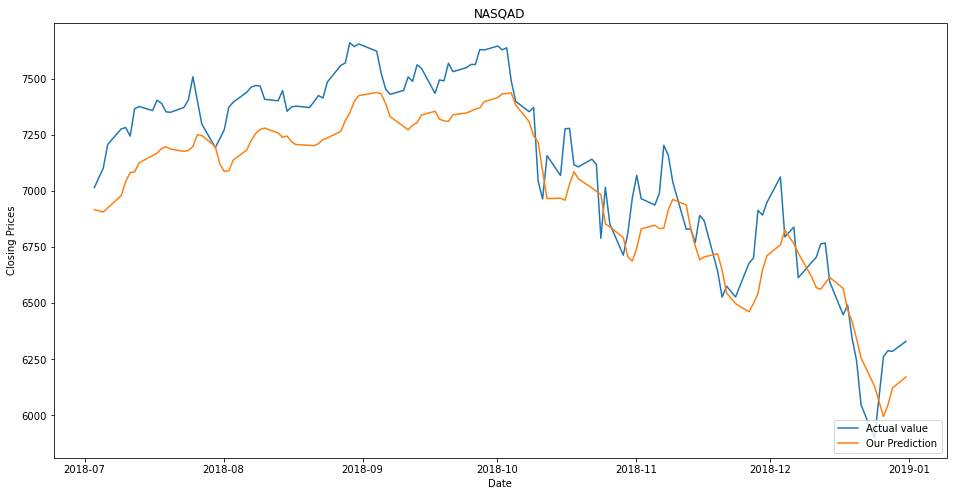

In [33]:
data1 = nasdaq.filter(['Close'])
train1 = data1[:training_data_len_nasqad]
validation1 = data1[training_data_len_nasqad:]
validation1['Predictions'] = predictions_nasqad
print(validation1)

plt.figure(figsize=(16,8))
plt.title('NASQAD')
plt.xlabel('Date')
plt.ylabel("Closing Prices")
plt.plot(validation1[['Close', 'Predictions']])
plt.legend(['Actual value', 'Our Prediction'], loc='lower right')
plt.show()

## SP500

In [11]:
# CLOSING PRICES
close_sp500 = sp500['Close']
values_sp500 = close_sp500.values
# TRAINING DATA
training_data_len_sp500 = math.ceil(len(values_sp500)* 0.95)
scaled_data_sp500 = scaler.fit_transform(values_sp500.reshape(-1,1))
train_data_sp500 = scaled_data_sp500[0: training_data_len_sp500, :] 

x_train_sp500 = []
y_train_sp500 = [] 
for i in range(60, len(train_data_sp500)):
    x_train_sp500.append(train_data_sp500[i-60:i, 0]) 
    y_train_sp500.append(train_data_sp500[i, 0]) 

x_train_sp500, y_train_sp500 = np.array(x_train_sp500), np.array(y_train_sp500)
x_train_sp500 = np.reshape(x_train_sp500, (x_train_sp500.shape[0], x_train_sp500.shape[1], 1))
# TESTING DATA
test_data_sp500 = scaled_data_sp500[training_data_len_sp500-60: , : ]
x_test_sp500 = []
y_test_sp500 = values_sp500[training_data_len_sp500:]
for i in range(60, len(test_data_sp500)):
    x_test_sp500.append(test_data_sp500[i-60:i, 0])
x_test_sp500 = np.array(x_test_sp500)
x_test_sp500 = np.reshape(x_test_sp500, (x_test_sp500.shape[0], x_test_sp500.shape[1], 1)) 

# getting the model from keras tensorflow
model_sp500 = keras.Sequential()
model_sp500.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_sp500.shape[1], 1)))
model_sp500.add(layers.LSTM(100, return_sequences=False))
model_sp500.add(layers.Dense(25))
model_sp500.add(layers.Dense(1))
model_sp500.summary()

model_sp500.compile(optimizer='adam', loss='mean_squared_error')
model_sp500.fit(x_train_sp500, y_train_sp500, batch_size= 1, epochs=3)

predictions_sp500 = model_sp500.predict(x_test_sp500)
predictions_sp500 = scaler.inverse_transform(predictions_sp500)
root_mean_square_error_sp500 = np.sqrt(np.mean(predictions_sp500 - y_test_sp500)**2)
print(root_mean_square_error_sp500)

data2 = sp500.filter(['Close'])
train2 = data2[:training_data_len_sp500]
validation2 = data2[training_data_len_sp500:]
validation2['Predictions'] = predictions_sp500

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2331/2331 [==============================] - 39s 16ms/step - loss: 9.5495e-04
Epoch 2/3
2331/2331 [==============================] - 36s 16ms/step - loss: 4.3399e-04
Epoc

C:\Users\nicko\AppData\Local\Temp/ipykernel_44736/57008899.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation2['Predictions'] = predictions_sp500


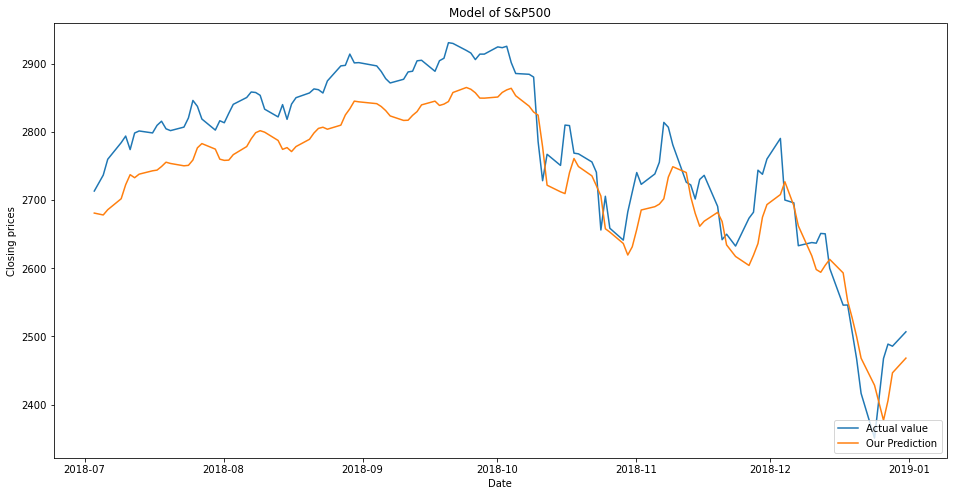

In [32]:
plt.figure(figsize=(16,8))
plt.title('Model of S&P500')
plt.xlabel('Date')
plt.ylabel('Closing prices')
plt.plot(validation2[['Close', 'Predictions']])
plt.legend(['Actual value', 'Our Prediction'], loc='lower right')
plt.show()

## Dow Jones

In [13]:
# CLOSING PRICES
close_dow_jones = dow_jones['Close']
values_dow_jones = close_dow_jones.values
# TRAINING DATA
training_data_len_dow_jones = math.ceil(len(values_dow_jones)* 0.95)
scaled_data_dow_jones = scaler.fit_transform(values_dow_jones.reshape(-1,1))
train_data_dow_jones= scaled_data_dow_jones[0: training_data_len_dow_jones, :] 

x_train_dow_jones = []
y_train_dow_jones = [] 
for i in range(60, len(train_data_dow_jones)):
    x_train_dow_jones.append(train_data_dow_jones[i-60:i, 0]) 
    y_train_dow_jones.append(train_data_dow_jones[i, 0]) 

x_train_dow_jones, y_train_dow_jones = np.array(x_train_dow_jones), np.array(y_train_dow_jones)
x_train_dow_jones = np.reshape(x_train_dow_jones, (x_train_dow_jones.shape[0], x_train_dow_jones.shape[1], 1))
# TESTING DATA
test_data_dow_jones = scaled_data_sp500[training_data_len_dow_jones-60: , : ]
x_test_dow_jones = []
y_test_dow_jones = values_dow_jones[training_data_len_dow_jones:]
for i in range(60, len(test_data_dow_jones)):
    x_test_dow_jones.append(test_data_dow_jones[i-60:i, 0])
x_test_dow_jones = np.array(x_test_dow_jones)
x_test_dow_jones = np.reshape(x_test_dow_jones, (x_test_dow_jones.shape[0], x_test_dow_jones.shape[1], 1)) 

# getting the model from keras tensorflow
model_dow_jones = keras.Sequential()
model_dow_jones.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_dow_jones.shape[1], 1)))
model_dow_jones.add(layers.LSTM(100, return_sequences=False))
model_dow_jones.add(layers.Dense(25))
model_dow_jones.add(layers.Dense(1))
model_dow_jones.summary()

model_dow_jones.compile(optimizer='adam', loss='mean_squared_error')
model_dow_jones.fit(x_train_dow_jones, y_train_dow_jones, batch_size= 1, epochs=3)

predictions_dow_jones = model_dow_jones.predict(x_test_dow_jones)
predictions_dow_jones = scaler.inverse_transform(predictions_dow_jones)
root_mean_square_error_dow_jones = np.sqrt(np.mean(predictions_dow_jones - y_test_dow_jones)**2)
print(root_mean_square_error_dow_jones)

data3 = dow_jones.filter(['Close'])
train3 = data3[:training_data_len_dow_jones]
validation3 = data3[training_data_len_dow_jones:]
validation3['Predictions'] = predictions_dow_jones

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2331/2331 [==============================] - 39s 16ms/step - loss: 0.0010
Epoch 2/3
2331/2331 [==============================] - 35s 15ms/step - loss: 3.6575e-04
Epoch 3/

C:\Users\nicko\AppData\Local\Temp/ipykernel_44736/460862292.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation3['Predictions'] = predictions_dow_jones


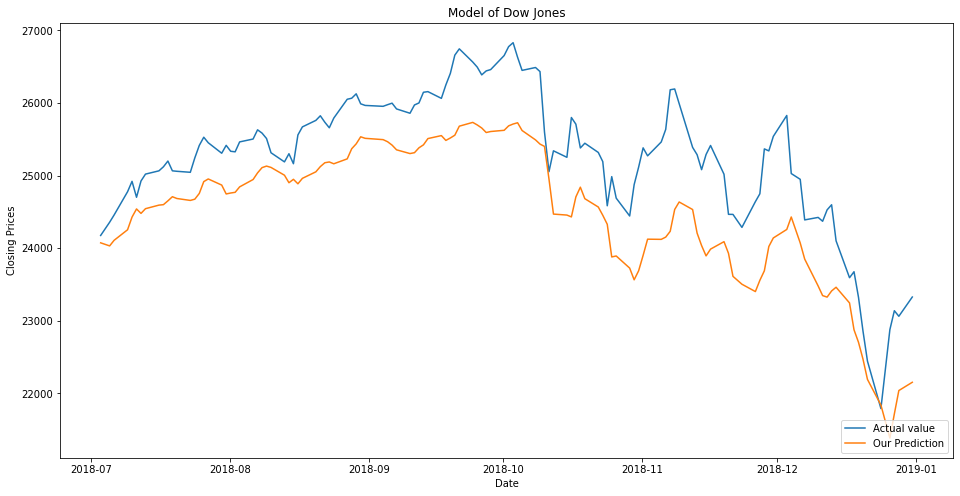

In [31]:
plt.figure(figsize=(16,8))
plt.title('Model of Dow Jones')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.plot(validation3[['Close', 'Predictions']])
plt.legend(['Actual value', 'Our Prediction'], loc='lower right')
plt.show()

In [ ]:
print(train1, train2, train3)

                                 Close
Date                                  
2009-01-02 00:00:00-05:00  1263.699951
2009-01-05 00:00:00-05:00  1262.520020
2009-01-06 00:00:00-05:00  1274.489990
2009-01-07 00:00:00-05:00  1238.599976
2009-01-08 00:00:00-05:00  1252.520020
...                                ...
2018-06-26 00:00:00-04:00  7068.200195
2018-06-27 00:00:00-04:00  6969.669922
2018-06-28 00:00:00-04:00  7031.600098
2018-06-29 00:00:00-04:00  7040.799805
2018-07-02 00:00:00-04:00  7097.819824

[2391 rows x 1 columns]                                  Close
Date                                  
2009-01-02 00:00:00-05:00   931.799988
2009-01-05 00:00:00-05:00   927.450012
2009-01-06 00:00:00-05:00   934.700012
2009-01-07 00:00:00-05:00   906.650024
2009-01-08 00:00:00-05:00   909.729980
...                                ...
2018-06-26 00:00:00-04:00  2723.060059
2018-06-27 00:00:00-04:00  2699.629883
2018-06-28 00:00:00-04:00  2716.310059
2018-06-29 00:00:00-04:00  2718.370117
